In [16]:
!wget https://raw.githubusercontent.com/tesemnikov-av/graph-rec-sys/main/kinopoisk-top250.csv > /dev/null
!pip install node2vec > /dev/null

--2022-01-15 15:33:52--  https://raw.githubusercontent.com/tesemnikov-av/graph-rec-sys/main/kinopoisk-top250.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 297908 (291K) [text/plain]
Saving to: ‘kinopoisk-top250.csv.5’

kinopoisk-top250.cs 100%[===================>] 290.93K  --.-KB/s    in 0.01s   

2022-01-15 15:33:52 (21.9 MB/s) - ‘kinopoisk-top250.csv.5’ saved [297908/297908]



In [17]:
import pandas as pd
import networkx as nx
from matplotlib.pyplot import figure
from node2vec import Node2Vec

In [18]:
df = pd.read_csv('kinopoisk-top250.csv')[['movie','actors', 'year', 'country', 'director']]

In [19]:
df.head()

movie  ...                       director
0  Побег из Шоушенка   ...                 Фрэнк Дарабонт
1       Зеленая миля   ...                 Фрэнк Дарабонт
2       Форрест Гамп   ...                 Роберт Земекис
3    Список Шиндлера   ...                Стивен Спилберг
4                1+1   ...   Оливье Накаш;  Эрик Толедано

[5 rows x 5 columns]

# Part One Networkx

In [20]:
df['movie'] = df['movie'].str.strip()
df['country'] = df['country'].str.strip()

edges = []
for index, row in df.iterrows():
    actors = row[1].split(';')
    movie = row[0]
    year = row[2]
    country = row[3]
    director = row[4].split(';')[0]
    for i in actors:
        for j in actors:
            if i !=j:
                edges.append((i.strip(), j.strip()))
                edges.append((i.strip(), movie))
                edges.append((director, movie))


In [21]:
edges[:10]

[('Тим Роббинс', 'Морган Фриман'),
 ('Тим Роббинс', 'Побег из Шоушенка'),
 (' Фрэнк Дарабонт', 'Побег из Шоушенка'),
 ('Тим Роббинс', 'Боб Гантон'),
 ('Тим Роббинс', 'Побег из Шоушенка'),
 (' Фрэнк Дарабонт', 'Побег из Шоушенка'),
 ('Тим Роббинс', 'Уильям Сэдлер'),
 ('Тим Роббинс', 'Побег из Шоушенка'),
 (' Фрэнк Дарабонт', 'Побег из Шоушенка'),
 ('Тим Роббинс', 'Клэнси Браун')]

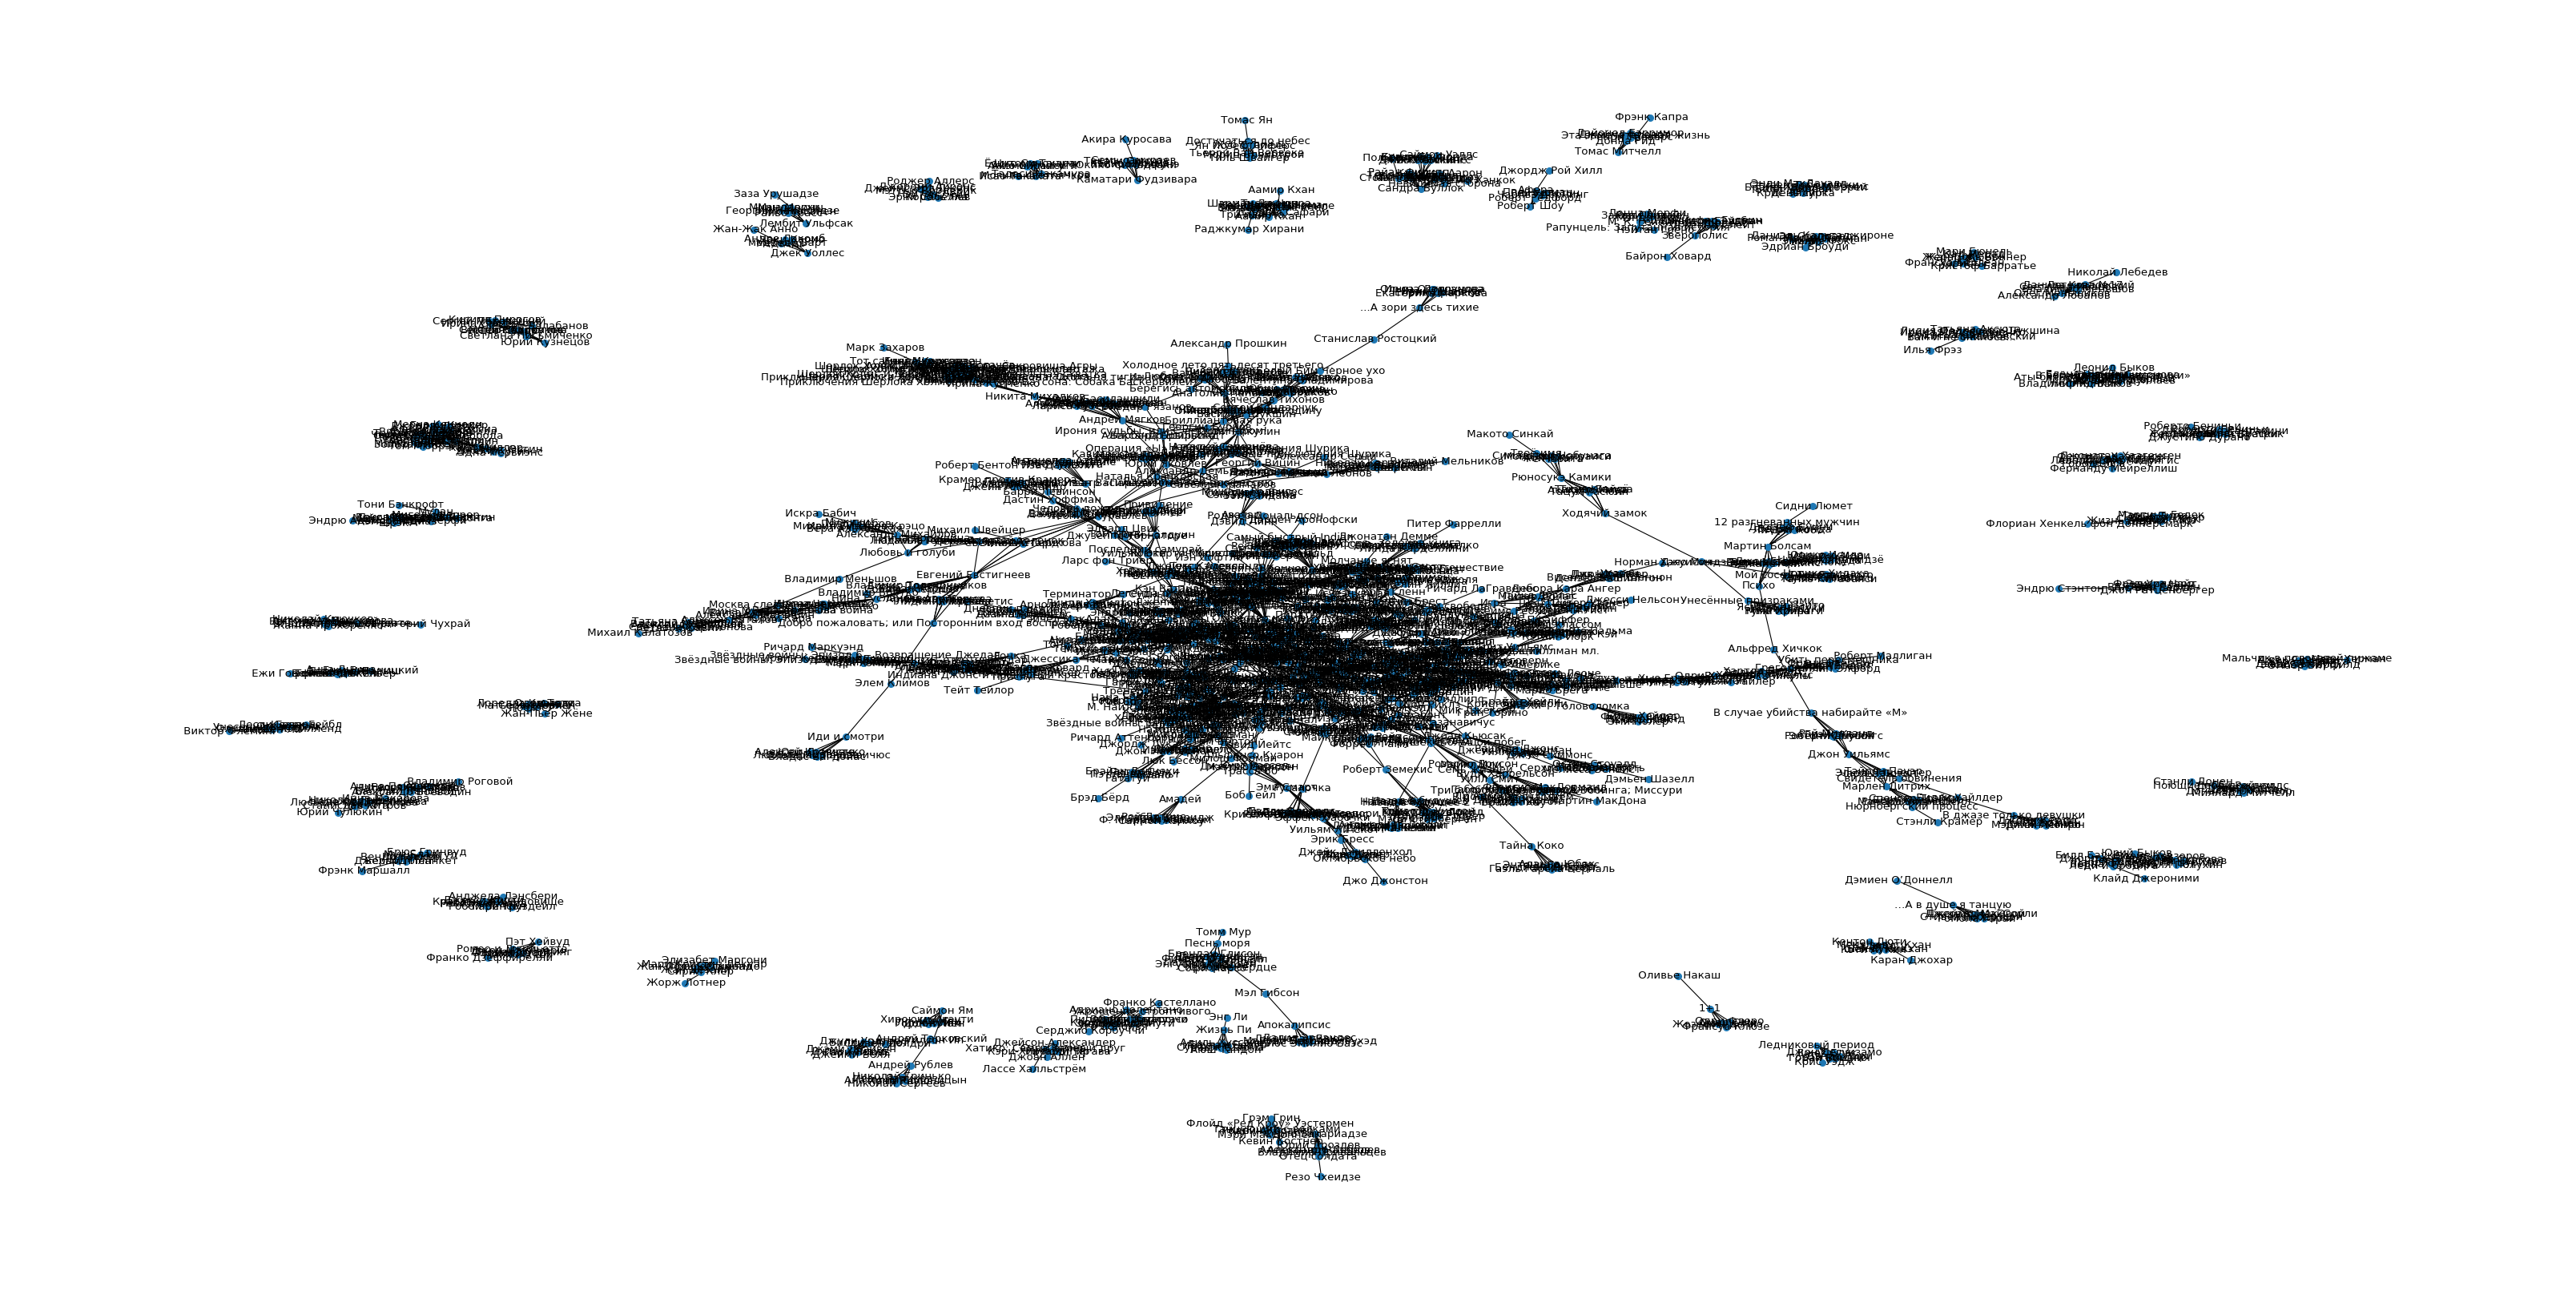

In [22]:
kinopoiskGraph = nx.Graph()
kinopoiskGraph.add_edges_from(edges)

figure(figsize=(40, 20), dpi=80)
nx.draw(kinopoiskGraph, with_labels = True,  node_size=50,)

In [26]:
recomendation = []

for neighbor_one in kinopoiskGraph.neighbors('Криминальное чтиво'):
    for neighbor_two in kinopoiskGraph.neighbors(neighbor_one):
        if neighbor_two in df['movie'].values and (str(neighbor_two).strip() not in df['country'].values):
            recomendation.append((neighbor_two, neighbor_one))

In [31]:
pd.DataFrame(recomendation, columns=['recomendation', 'relation'])

recomendation            relation
0                        Криминальное чтиво       Джон Траволта
1                        Криминальное чтиво   Квентин Тарантино
2                      Джанго освобожденный   Квентин Тарантино
3                               Бешеные псы   Квентин Тарантино
4                        Криминальное чтиво   Сэмюэл Л. Джексон
5                      Джанго освобожденный   Сэмюэл Л. Джексон
6   Звёздные войны: Эпизод 3 – Месть Ситхов   Сэмюэл Л. Джексон
7                             Тренер Картер   Сэмюэл Л. Джексон
8                        Криминальное чтиво         Брюс Уиллис
9                            Шестое чувство         Брюс Уиллис
10                 Счастливое число Слевина         Брюс Уиллис
11                            Пятый элемент         Брюс Уиллис
12                           Крепкий орешек         Брюс Уиллис
13                       Криминальное чтиво          Ума Турман
14                                  Гаттака          Ума Турман
15                       Криминальное чтиво          Винг Реймз

# Part Two Node2Vec

In [32]:
edges2 = []
for index, row in df.iterrows():
    actors = row[1].split(';')
    movie = row[0]
    year = row[2]
    country = row[3]
    director = row[4].split(';')[0]
    for i in actors:
        for j in actors:
            if i !=j:
                edges2.append((i.strip(), j.strip()))
                edges2.append((i.strip(), movie))
                edges2.append((director, movie))
                edges2.append((country, movie))
                edges2.append((year, movie))

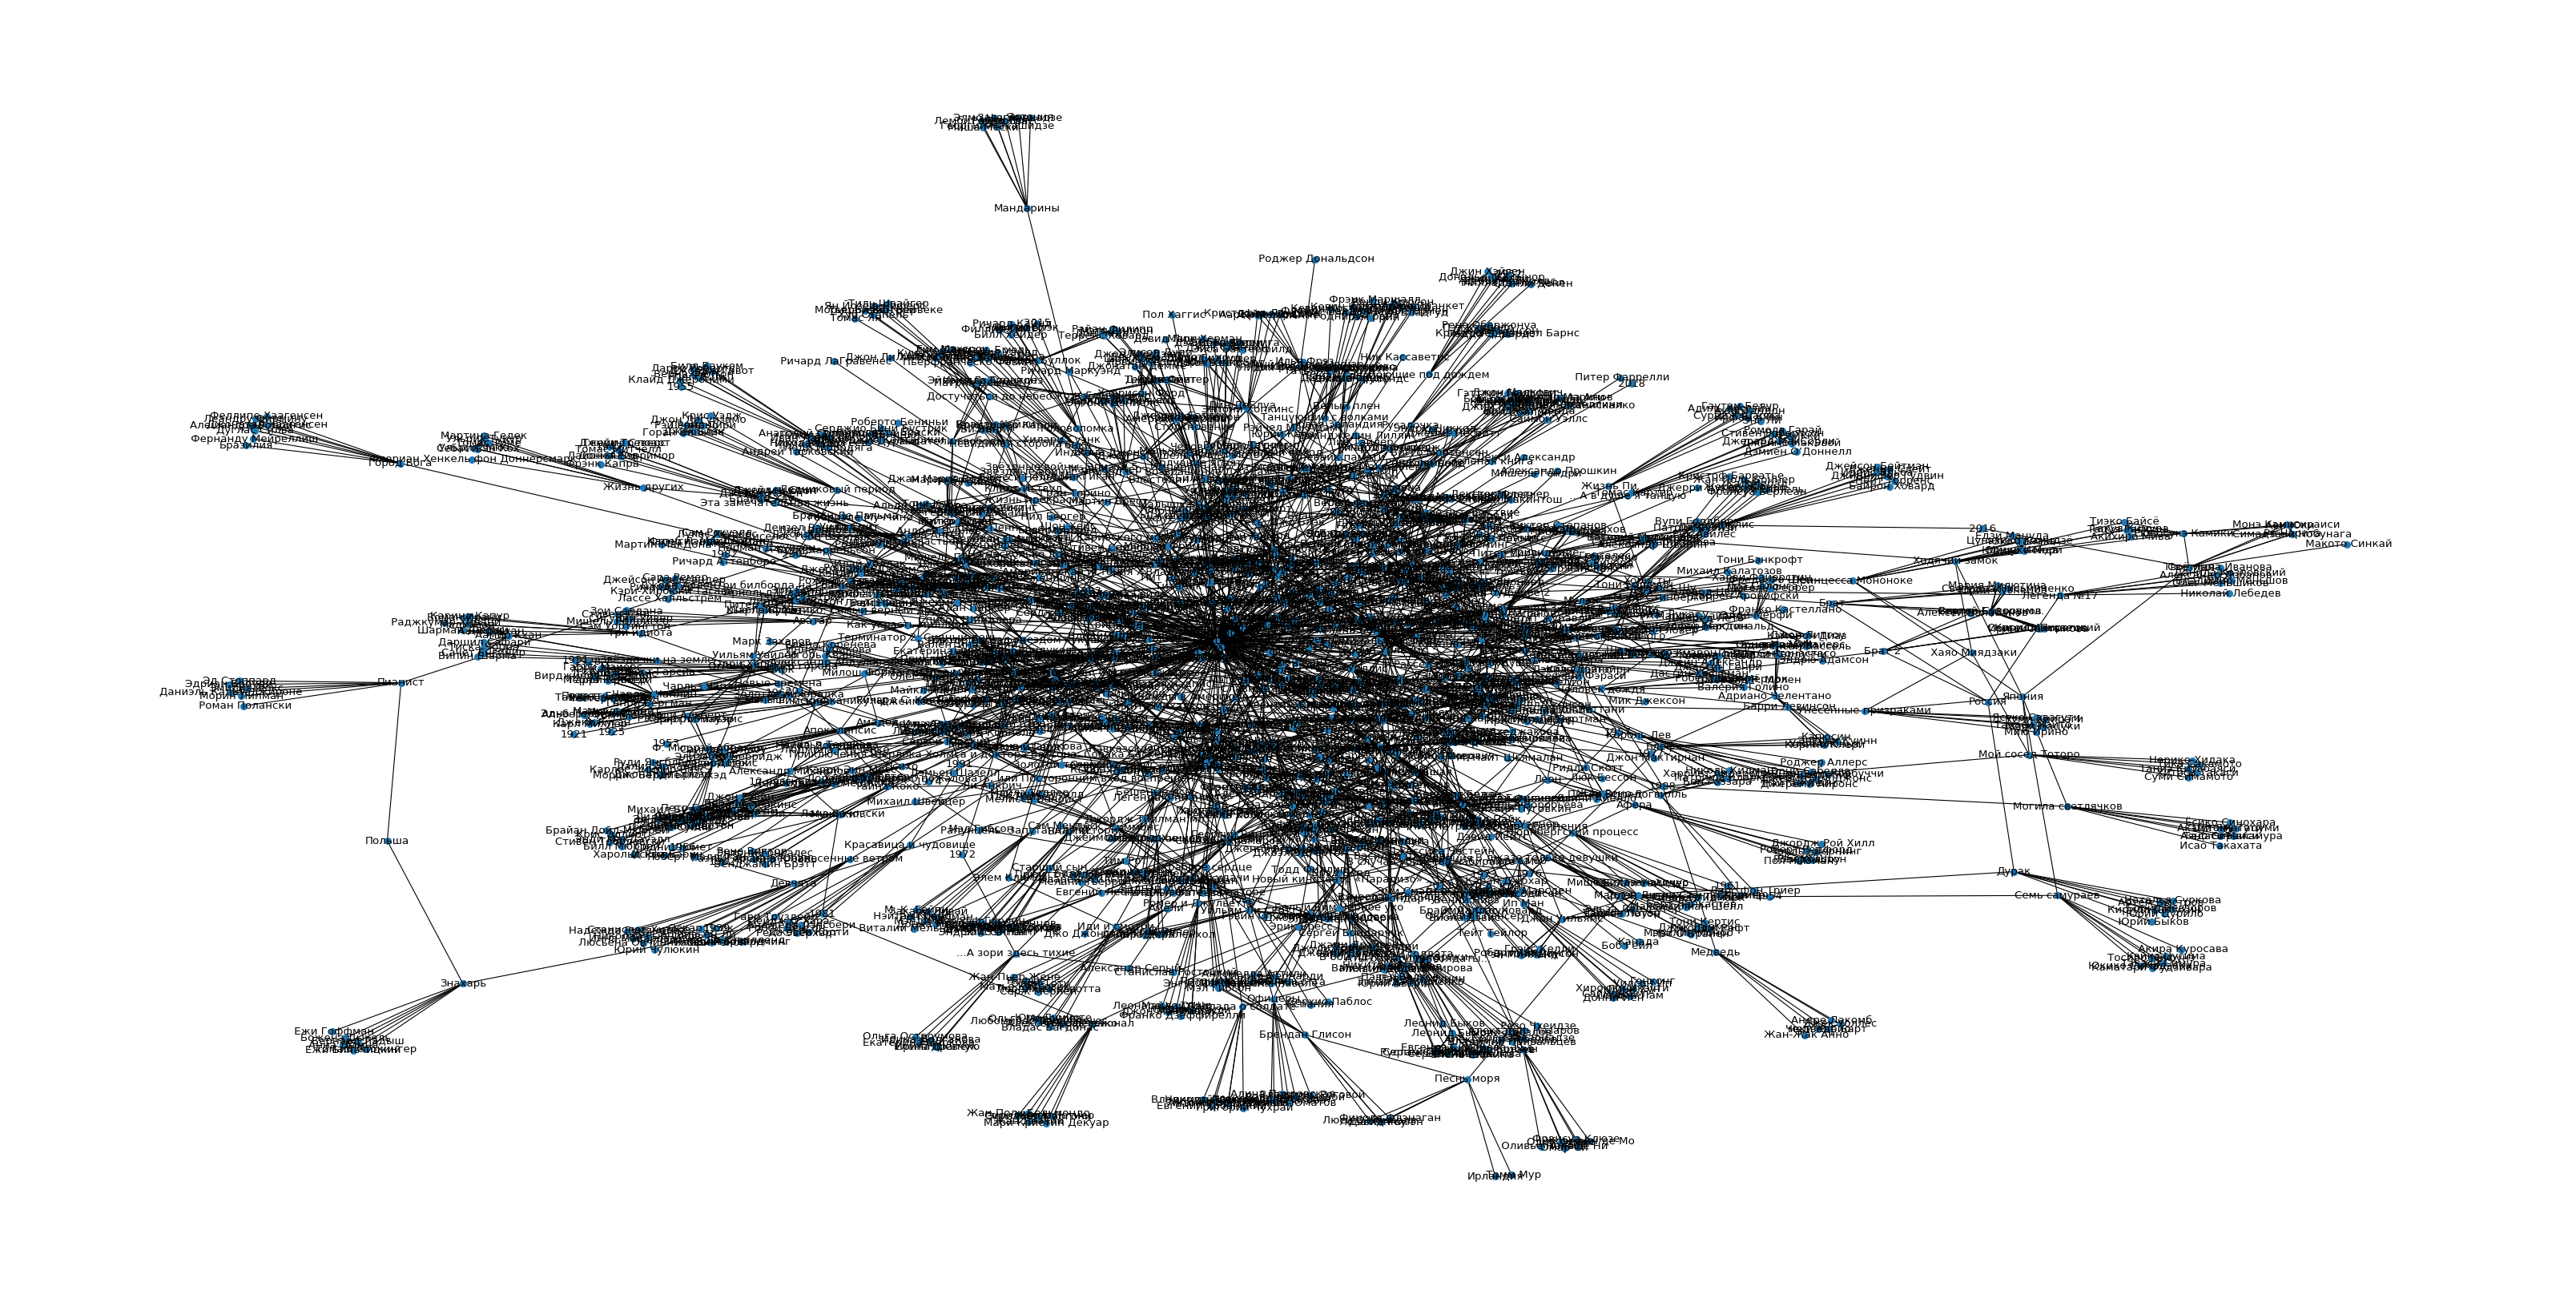

In [33]:
kinopoiskGraph2 = nx.Graph()
kinopoiskGraph2.add_edges_from(edges2)

figure(figsize=(40, 20), dpi=80)
nx.draw(kinopoiskGraph2, with_labels = True,  node_size=50,)

In [35]:
node2vec = Node2Vec(kinopoiskGraph2, dimensions=16, walk_length=4, num_walks=100, workers=4)
model = node2vec.fit(window=4)

Computing transition probabilities:   0%|          | 0/1481 [00:00<?, ?it/s]

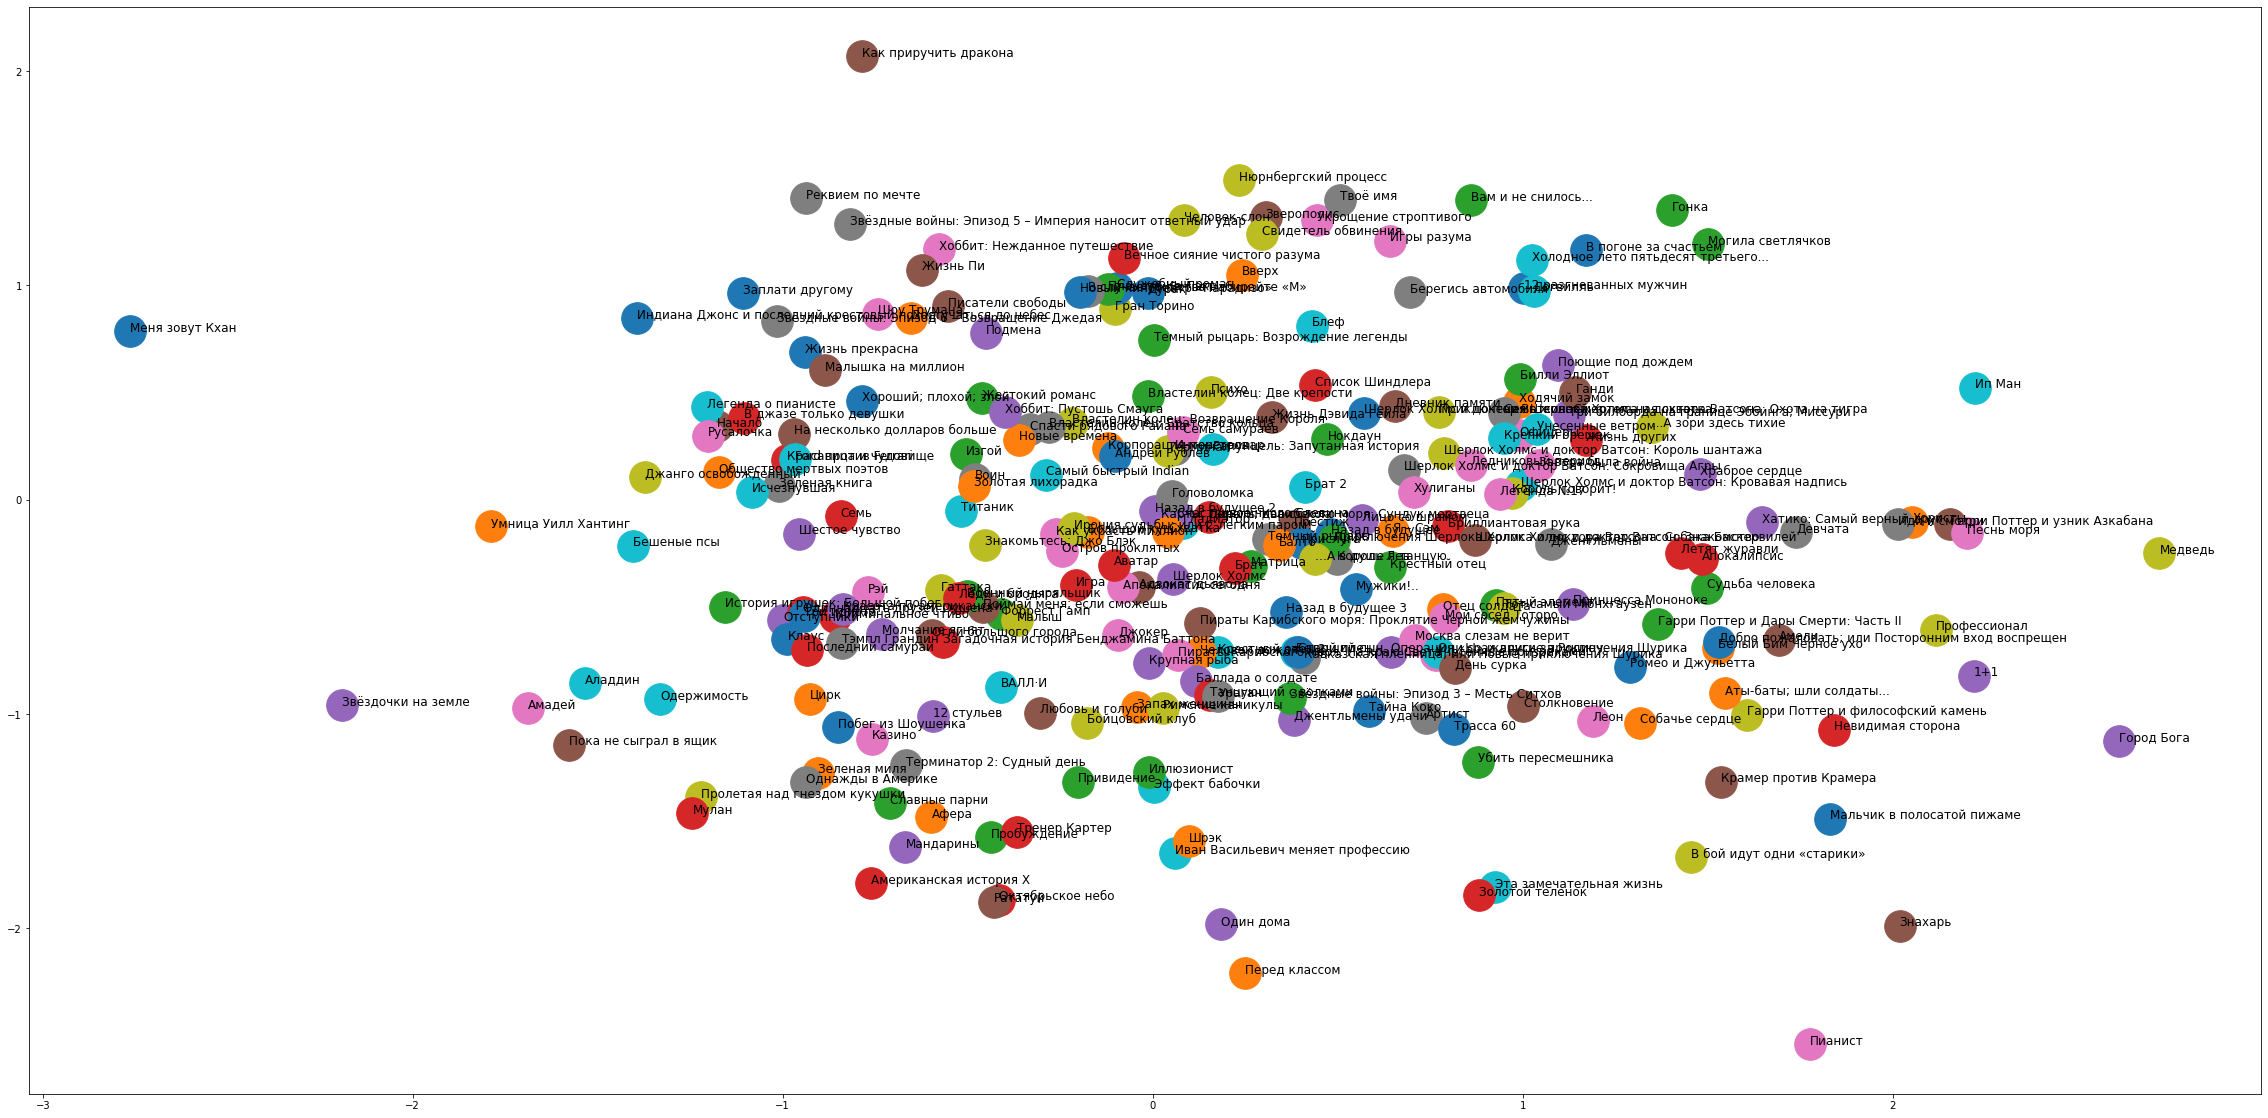

In [36]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(40, 20))
for x in kinopoiskGraph2.nodes():
    if str(x).strip() in df['movie'].values:
        v = model.wv.get_vector(str(x))
        ax.scatter(v[0],v[1], s=1000)
        ax.annotate(str(x), (v[0],v[1]), fontsize=12)
    

In [38]:
model.wv.most_similar('Ума Турман')

[('Джон Траволта', 0.9682013988494873),
 ('Лорен Дин', 0.9645958542823792),
 ('Винг Реймз', 0.9578862190246582),
 ('Алан Аркин', 0.9570324420928955),
 ('Криминальное чтиво', 0.952869713306427),
 (' Эндрю Никкол', 0.9139379262924194),
 ('Гаттака', 0.9033907651901245),
 ('Итан Хоук', 0.900732159614563),
 ('Джуд Лоу', 0.8954352140426636),
 ('Сэмюэл Л. Джексон', 0.8717272281646729)]